## Adam, 배치정규화, 드롭아웃, ReLU, HE uniform Initialization 적용

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print("장비 : {}".format(DEVICE))

장비 : cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [19]:
train_dataset = datasets.MNIST(root = './Data/MNIST',train = True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root = './Data/MNIST',train = False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [20]:
for (x_train, y_train) in train_loader:
    print(x_train.size(), x_train.type())
    print(y_train.size(), y_train.type())
    break

torch.Size([32, 1, 28, 28]) torch.FloatTensor
torch.Size([32]) torch.LongTensor


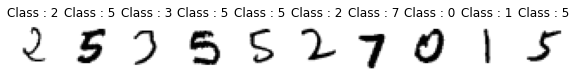

In [21]:
pltsize= 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
    plt.title('Class : ' + str(y_train[i].item())) 

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p = self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [23]:
import torch.nn.init as init
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [24]:
def train(model, train_loader, optimizer,log_interval):
    model.train()
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        # loss값 계산
        loss = criterion(output, label)
        # loss 값 계산한 것을 바탕으로 역전파알고리즘을 통해 계산된 기울기 값을 각 파라미터에 할당
        loss.backward()
        # 가중치 업데이트
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{} / {} ({:.0f}%)]\t Train Loss : {:.6f}".format(Epoch, batch_idx * len(image),len(train_loader.dataset), 100.*batch_idx / len(train_loader),loss.item()))

In [25]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [26]:
for Epoch in range(1,EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH : {}], \t Test Loss : {:.4f}, \t Test Accuracy : {:2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch : 1 [0 / 60000 (0%)]	 Train Loss : 3.339149
Train Epoch : 1 [6400 / 60000 (11%)]	 Train Loss : 0.215261
Train Epoch : 1 [12800 / 60000 (21%)]	 Train Loss : 0.184364
Train Epoch : 1 [19200 / 60000 (32%)]	 Train Loss : 0.136987
Train Epoch : 1 [25600 / 60000 (43%)]	 Train Loss : 0.377442
Train Epoch : 1 [32000 / 60000 (53%)]	 Train Loss : 0.237679
Train Epoch : 1 [38400 / 60000 (64%)]	 Train Loss : 0.226958
Train Epoch : 1 [44800 / 60000 (75%)]	 Train Loss : 0.166236
Train Epoch : 1 [51200 / 60000 (85%)]	 Train Loss : 0.507232
Train Epoch : 1 [57600 / 60000 (96%)]	 Train Loss : 0.327446

[EPOCH : 1], 	 Test Loss : 0.0040, 	 Test Accuracy : 95.910000 %

Train Epoch : 2 [0 / 60000 (0%)]	 Train Loss : 0.146607
Train Epoch : 2 [6400 / 60000 (11%)]	 Train Loss : 0.260558
Train Epoch : 2 [12800 / 60000 (21%)]	 Train Loss : 0.377698
Train Epoch : 2 [19200 / 60000 (32%)]	 Train Loss : 0.468174
Train Epoch : 2 [25600 / 60000 (43%)]	 Train Loss : 0.259656
Train Epoch : 2 [32000 / 60000